In [2]:
import os
import re
import string

import nltk
import polars as pl
import tensorflow as tf
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
file = 'dev.gzip'
dev_df = pl.read_parquet(file)
dev_df.head()

Log,Target
str,str
""" 1119803499 20…","""normal"""
""" 1119803105 20…","""normal"""
""" 1121496169 20…","""normal"""
""" 1120968564 20…","""normal"""
""" 1120953205 20…","""normal"""


In [1]:
from utils.utils import get_dataset, text_vec

In [4]:
dev_dataset = get_dataset(file_path= file, batch_size=1,shuffle= False)

In [6]:
for word in dev_dataset.take(2):
    print(word)

(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'rmnccju rmnccju ras kernel info data store interrupt caused dcbf'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
(<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'rmnecju rmnecju ras kernel info program interrupt illegal instruction'],
      dtype=object)>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)


In [20]:
token_vec, voc = text_vec(dev_dataset)

In [21]:
out = token_vec(['rmnccju rmnccju ras kernel info data store interrupt caused dcbf'])
out

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 26,  26,   3,   4,   5,  35,  75,  25,  95, 242,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
log_ds = dev_dataset.map(lambda text,label: text)
sequence_length = 10
tokenizer_layer = tf.keras.layers.TextVectorization(split= 'whitespace', output_mode= 'int',
                                              output_sequence_length= sequence_length)
tokenizer_layer.adapt(log_ds)
vocab_size = tokenizer_layer.vocabulary_size()

In [4]:
vocab_size = 1000

In [14]:
LR = 0.001
OPTIM = tf.keras.optimizers.Adam(learning_rate=LR)
LOSS = "binary_crossentropy"
filter = 10
kernel = 5
stride = 1
pad= "same"
embed_dim = 100

def build_model():
    """ 1DCNN doc

    Parameters
    ----------
    file_path : str

    Returns
    -------
    model : object
        model
    """
    input_layer = tf.keras.layers.Input(shape= (100))
    embeding_layer = tf.keras.layers.Embedding(input_dim= vocab_size + 1,output_dim= embed_dim,
                                               mask_zero= True)
    DefaultConv1D = partial(tf.keras.layers.Conv1D, kernel_size= 3, strides= 1 , padding= pad, 
                           activation= 'relu')
    DefualtMaxpool1D = partial(tf.keras.layers.MaxPool1D, pool_size= 2)
    model = tf.keras.Sequential([input_layer, embeding_layer,
                         DefaultConv1D(30),
                         DefualtMaxpool1D(),
                         tf.keras.layers.GlobalMaxPool1D(),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(units= 20, activation= 'relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(units= 1, activation= 'sigmoid')
                         ])
    model.compile(loss= LOSS, optimizer= OPTIM, metrics= ['f1_score'])
    return model

In [15]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          100100    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 30)           9030      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 30)            0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_3 (Gl  (None, 30)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 dense_6 (Dense)             (None, 20)               

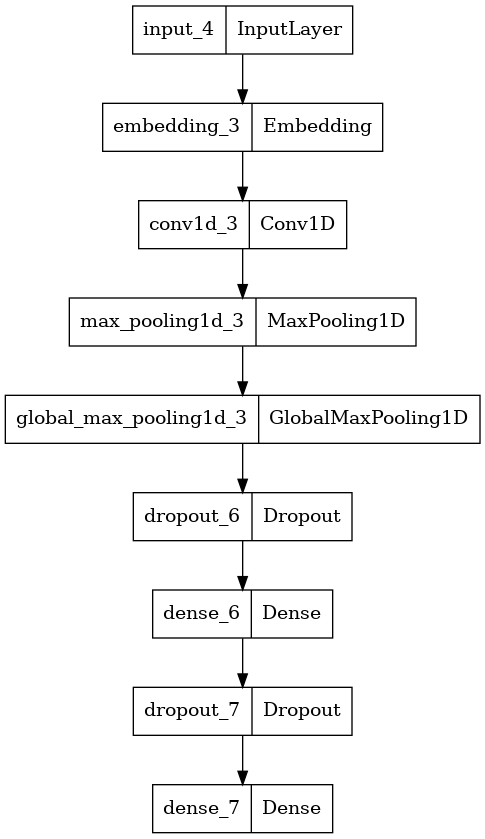

In [16]:
tf.keras.utils.plot_model(model,
                          to_file= 'doc/model.png')

In [15]:
import os
from functools import partial

import tensorflow as tf

os.chdir("../")

In [22]:
from models import GRU

new_model = GRU.build_model(100,100,'same',100,token_vec)
new_model.summary()

ValueError: Exception encountered when calling layer "text_vectorization_2" (type TextVectorization).

When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 100) with rank=2

Call arguments received by layer "text_vectorization_2" (type TextVectorization):
  • inputs=tf.Tensor(shape=(None, 100), dtype=float32)